In [105]:
# import library and load dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
# accuracy, precision, recall, f1 score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)
# load datasetp
data_path = '../../data/processed/data_cleaned_scaled_onehot.csv' 
data = pd.read_csv(data_path)

# form features and target
X = data.drop(['Target'], axis=1)
y = data['Target']

# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [106]:
# hyperparameter search for SVM
from sklearn.svm import SVC

svc = SVC(class_weight='balanced')
param_grid = {'C': [1, 10, 100, 200, 500, 1000], 
              'gamma': [0.1, 0.01, 0.001, 0.0001, 0.00001], 
              'kernel': ['rbf', 'sigmoid', 'poly']}
# scoring on both accuracy and recall
grid = GridSearchCV(svc, param_grid, refit=True, scoring='roc_auc', verbose=2, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_estimator_)
gscore = grid.score(X_train, y_train)
print(gscore)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
{'C': 200, 'gamma': 0.0001, 'kernel': 'rbf'}
SVC(C=200, class_weight='balanced', gamma=0.0001)
0.9312834393601952


Threshold: 0.08 Recall: 0.8894 Accuracy: 0.7232
Threshold: 0.09 Recall: 0.8850 Accuracy: 0.7415
Threshold: 0.10 Recall: 0.8805 Accuracy: 0.7585
Threshold: 0.11 Recall: 0.8761 Accuracy: 0.7768
Threshold: 0.12 Recall: 0.8628 Accuracy: 0.7853
Threshold: 0.13 Recall: 0.8584 Accuracy: 0.7980
Threshold: 0.14 Recall: 0.8496 Accuracy: 0.8065
Threshold: 0.15 Recall: 0.8451 Accuracy: 0.8093
Threshold: 0.16 Recall: 0.8407 Accuracy: 0.8164
Threshold: 0.17 Recall: 0.8319 Accuracy: 0.8192
Threshold: 0.18 Recall: 0.8274 Accuracy: 0.8220
Threshold: 0.19 Recall: 0.8186 Accuracy: 0.8305


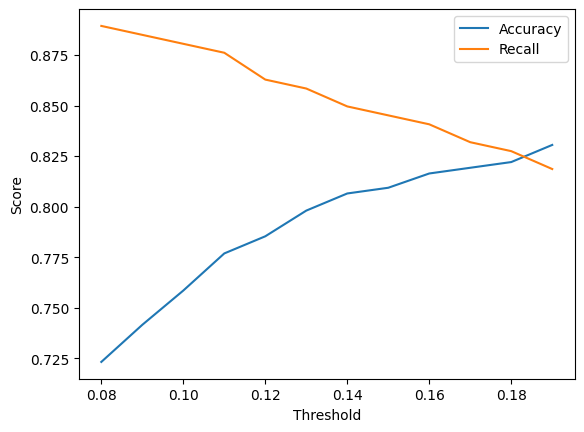

In [107]:
# hyper parameter search for decision threshold

# split traning set into training and validation set
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

classifier = SVC(kernel='rbf', gamma=0.0001, C=200, random_state=42, class_weight='balanced', probability=True)
classifier.fit(X_train_sub, y_train_sub)
y_pred_prob = classifier.predict_proba(X_val)[:, 1]
# hyperparameter search for SVM
accuracys = []
recalls = []
for threshold in np.arange(0.08, 0.20, 0.01):
    y_pred = y_pred_prob > threshold
    # format and print threshold with .2f
    print('Threshold: {:.2f} Recall: {:.4f} Accuracy: {:.4f}'.format(threshold, recall_score(y_val, y_pred), accuracy_score(y_val, y_pred)))

    accuracys.append(accuracy_score(y_val, y_pred))
    recalls.append(recall_score(y_val, y_pred))

plt.plot(np.arange(0.08, 0.20, 0.01), accuracys, label='Accuracy') 
plt.plot(np.arange(0.08, 0.20, 0.01), recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

In [108]:
# use cross validation to evaluate model consistency on X_train_scaled data
from sklearn.svm import SVC

svm = SVC(kernel='rbf', gamma=0.0001, C=200, random_state=42, class_weight='balanced')
scores = cross_val_score(svm, X_train, y_train, cv=10, scoring='recall')
print("recall mean:", scores.mean(), "recall std:", scores.std())

scores = cross_val_score(svm, X_train, y_train, cv=10, scoring='accuracy')
print("accuracy mean:", scores.mean(), "accuracy std:", scores.std())

recall mean: 0.8270843570843571 recall std: 0.029114529934501053
accuracy mean: 0.8705822570061299 accuracy std: 0.011317278521159815


In [109]:
# classification with kernel svm

from sklearn.metrics import confusion_matrix

classifier = SVC(kernel='rbf', gamma=0.0001, C=200, random_state=42, class_weight='balanced', probability=True)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
y_test_proba = classifier.predict_proba(X_test)[:, 1]
print('Recall:', recall_score(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("")
print("Confusion Matrix: [TP, FP], [FN, TN]")
print(cm)

Recall: 0.8132911392405063
Accuracy: 0.8497175141242937
Precision: 0.7764350453172205
F1 Score: 0.794435857805255

Confusion Matrix: [TP, FP], [FN, TN]
[[495  74]
 [ 59 257]]


In [110]:
# I can also increase recall by lowering the decision threshold
decision_threshold = 0.12
y_pred = y_test_proba > decision_threshold
print('Recall:', recall_score(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))
print('Confusion Matrix: [TP, FP], [FN, TN]')
print(confusion_matrix(y_test, y_pred))

Recall: 0.9177215189873418
Accuracy: 0.7853107344632768
Precision: 0.6387665198237885
F1 Score: 0.7532467532467533
Confusion Matrix: [TP, FP], [FN, TN]
[[405 164]
 [ 26 290]]


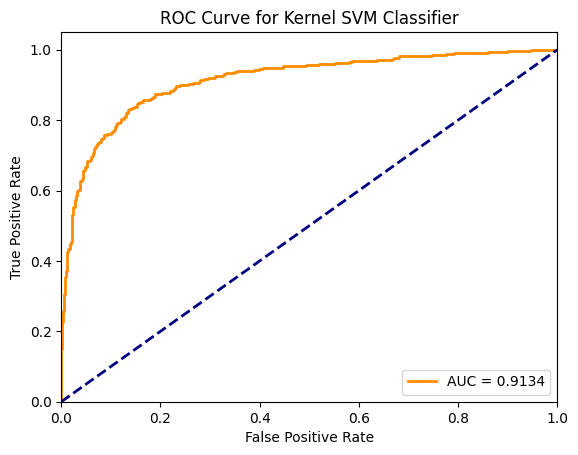

In [111]:
# roc curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
# auc
from sklearn.metrics import auc

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.4f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('ROC Curve for Kernel SVM Classifier')
plt.legend(loc="lower right")
plt.show()
